In [1]:
# iPython magic to autoreload modules everytime code is executed to propagate changes to the code
%load_ext autoreload
%autoreload 2

In [26]:
from pathlib import Path
from copy import deepcopy

import coderdata as cd
from coderdata.utils.stats import summarize_response_metric
from coderdata.utils.stats import plot_response_metric
from coderdata.utils.stats import prepare_2d_hist_data

import matplotlib.pyplot as plt
import math
import os

import seaborn as sns
import pandas as pd

In [5]:
os.makedirs('/tmp/coderdata', exist_ok=True)
os.chdir('/tmp/coderdata')

In [9]:
dataset_name = 'beataml'

In [ ]:

data = cd.load(name=dataset_name,local_path='/tmp/coderdata/in')
summary_stats = summarize_response_metric(data=data)
summary_stats

Importing raw data ...
Importing 'transcriptomics' from /tmp/coderdata/in/beataml_transcriptomics.csv.gz ... DONE
Importing 'genes' from /tmp/coderdata/in/genes.csv.gz ... DONE
Importing 'drugs' from /tmp/coderdata/in/beataml_drugs.tsv.gz ... DONE
Importing 'proteomics' from /tmp/coderdata/in/beataml_proteomics.csv.gz ... DONE
Importing 'drug_descriptors' from /tmp/coderdata/in/beataml_drug_descriptors.tsv.gz ... DONE
Importing 'mutations' from /tmp/coderdata/in/beataml_mutations.csv.gz ... DONE
Importing 'samples' from /tmp/coderdata/in/beataml_samples.csv ... DONE
Importing 'experiments' from /tmp/coderdata/in/beataml_experiments.tsv.gz ... DONE
Importing raw data ... DONE


,count,mean,std,min,25%,50%,75%,max
dose_response_metric,,,,,,,,
aac,23662.0,3.017679e-01,1.816163e-01,0.0000,0.1658,0.26300,0.413200,9.999000e-01
auc,23662.0,6.982321e-01,1.816163e-01,0.0001,0.5868,0.73700,0.834200,1.000000e+00
dss,23662.0,1.711991e-01,4.111407e-01,-0.0505,0.0000,0.14995,0.272275,3.591000e+01
fit_auc,23662.0,7.155576e-01,1.304242e-01,0.0376,0.6344,0.72160,0.806900,1.000000e+00
fit_ec50,23662.0,-3.020852e-01,1.702730e+00,-5.0000,-1.2200,-0.30815,0.751875,3.000000e+00
fit_ec50se,23662.0,9.411055e+08,1.376440e+11,0.0000,0.6697,1.68450,9.687000,2.116000e+13
fit_einf,23662.0,2.753041e-01,3.052878e-01,0.0000,0.0000,0.15480,0.532000,1.000000e+00
fit_hs,23662.0,-5.325079e-01,5.458597e-01,-1.0000,-1.0000,-0.65160,-0.266025,1.000000e+00
fit_ic50,17192.0,-4.941129e-01,8.307586e+01,-10410.0000,-0.6530,0.29335,1.022250,1.354000e+03


In [7]:
metrics = summary_stats.index.values

In [8]:
ncol = 3
nrow = math.ceil(len(metrics)/ncol)

Text(0.5, 0.98, 'Distribution of drug response values in "beataml"')

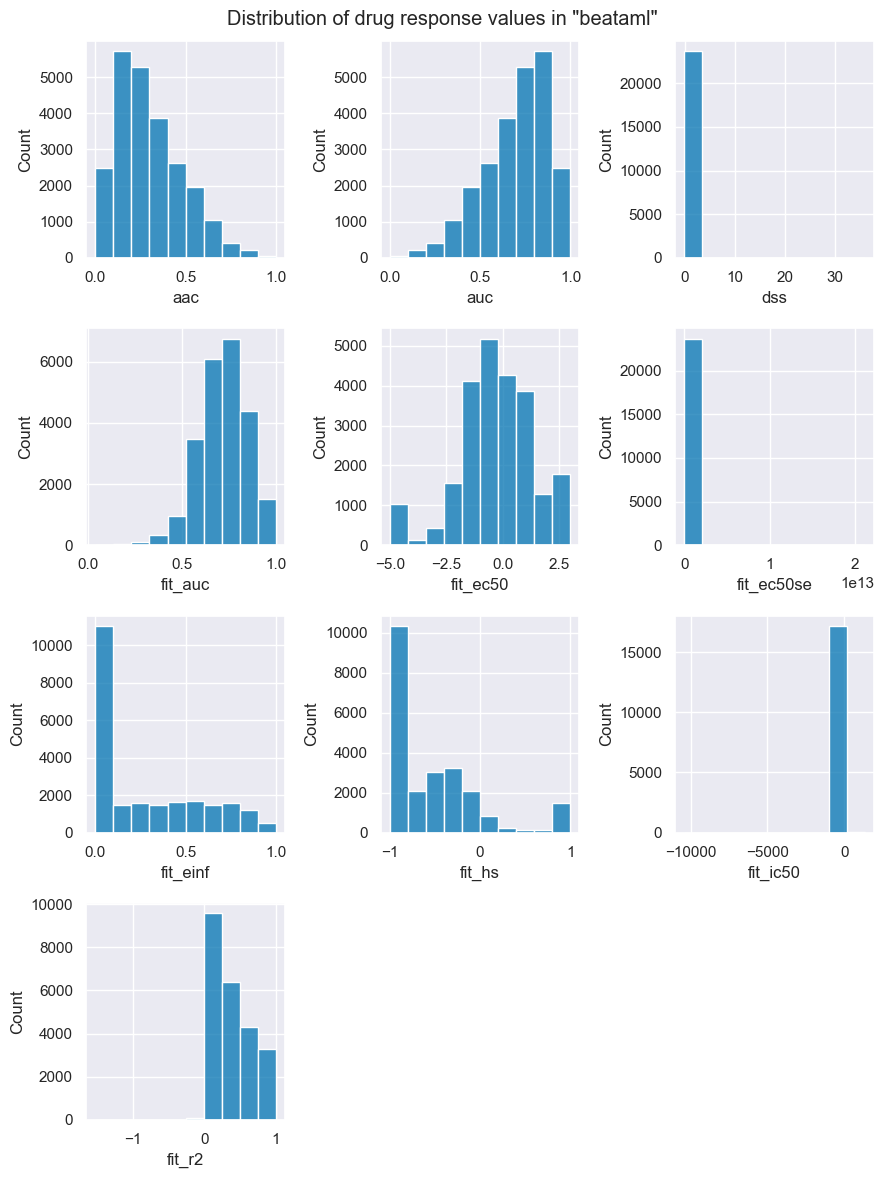

In [11]:
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*3, nrow*3))

k = 0
for i in range(0, nrow):
    for j in range(0, ncol):
        if k < len(metrics):
            plot_response_metric(data=data, metric=metrics[k], bins=10, ax=axs[i, j])
        else:
            axs[i, j].axis('off')
        k += 1

fig.set_layout_engine('tight')
fig.suptitle(f'Distribution of drug response values in "{dataset_name}"')

# uncomment next line to save plot
# fig.savefig(f'{dataset_prefix}.png')

For temporary import (development) of tabulated experiments files, i.e. the data that should normally be located in the `experiments` object of the data loaded via `cd.DatasetLoader()` we can also use pandas directly

In [ ]:
## Datasets from October (before allowing hill slope to be positive)

# experiment = "GDSC_v2"
# file_name = "gdsc2Output.tsv"

# experiment = "CTRP"
# file_name = "ctrpOutput.tsv"

# experiment = "NCI60"
# file_name = "nciOutput.tsv"

# data_experiments = pd.read_csv(file_name, sep='\t')

In [ ]:
## Dataset from 2024-11-01 (after allowing hill slope to be positive)

# experiment = "GDSC_v2-HillSlope+_R2-leq0-excluded"
# file_name = "gdsc2AllCurve.tsv"

experiment = "CTRP-HillSlope+_R2-leq0-excluded"
file_name = "ctrpAllCurve.tsv"

# experiment = "Prism-HillSlope+_R2-leq0-included"
# file_name = "prismAllCurve.tsv"

data_experiments = pd.read_csv(file_name, sep='\t')

Alternatively we just extract the `experiments` object of the data and prepare it for further plotting

In [12]:
experiment = "BeatAML"
data_experiments = data.experiments

We prepare the data table such that each drug_response_metric has it's own column with associated values

In [13]:
data_plot = prepare_2d_hist_data(data_experiments, r2=0)
# data_plot = _prepare_2d_hist_data(data_experiments)


Finally we define the metrics we want to plot, generate the figure and save it.

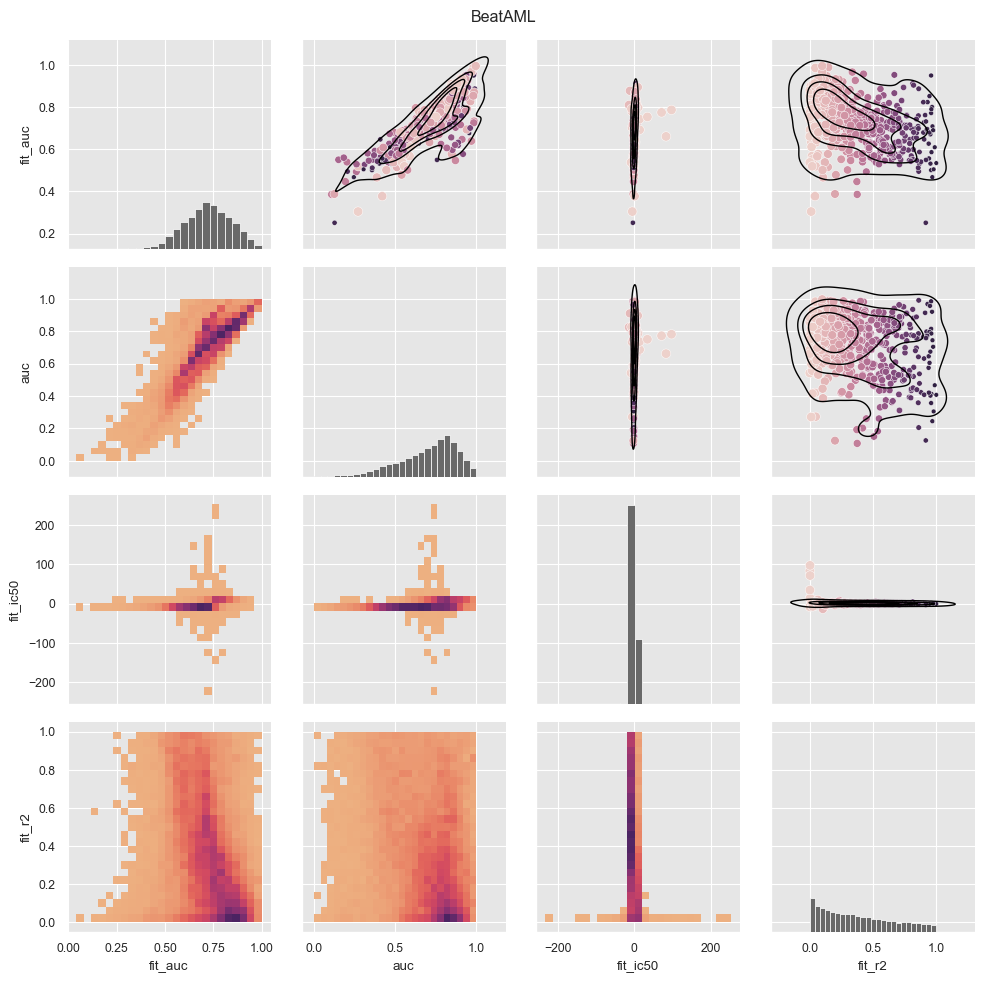

In [22]:
# metrics = [
#     "aac", "auc", "dss",
#     "fit_auc", "fit_ec50", "fit_ec50se",
#     "fit_einf", "fit_hs", "fit_ic50",
#     "fit_r2",
#     ]

# metrics = ["auc", "fit_auc", "fit_ec50", "fit_hs", "fit_r2"]
metrics = ["fit_auc", "auc", "fit_ic50", "fit_r2"]

# setting up the "theme context" aswell as the style
sns.set_theme(context="paper")
sns.set_style("darkgrid",{"axes.facecolor": ".9"})

# defining a color palette for the 2D histogram
joint_color_p = sns.color_palette("flare", as_cmap=True)

# generating an empty seaborn PairGrid object based on the plotting data
# the grid will be n x n where n is the number of metrics we plot 
pg = sns.PairGrid(
    data_plot,
    vars=metrics
    )

# generating the diagonal i.e. histograms of the drug response metric 
# value distributions
pg.map_diag(sns.histplot, bins=25, facecolor="dimgrey")

# generating the lower triangle of the grid where we plot 2D histograms
# of metric1 vs metric2 distributions
pg.map_lower(sns.histplot, bins=25, cmap=joint_color_p)

# subsampling the plotting data to 500 datapoints 
if data_plot.shape[0] > 500:
    pg.data = data_plot.sample(n=500, random_state=42)

# plotting the subsampled data as scatter plot in the upper triangle
# points are sized according to the inverse of their "fit_r2" value
# (larger points have a smaller "fit_r2 value")
# additionally the points are also colored according to their "fit_r2"
# value where darker hues are larger values
pg.map_upper(
    sns.scatterplot,
    size=max(pg.data["fit_r2"])-pg.data["fit_r2"],
    hue=pg.data["fit_r2"],
    )
# plotting a 2D kernel density distribution over the subsampled data 
# points in the upper triangle
pg.map_upper(sns.kdeplot, levels=5, color="black", linewidths=1 )

# adjusting the size of the top margin of grid and giving the plot a 
# title
pg.figure.subplots_adjust(top=.95)
pg.figure.suptitle(f"{experiment}")

# saving the plot according to the experiment name
pg.savefig(f"{experiment}-combined.pdf")

In [17]:
data_for_corr = data_plot.drop(columns=["source", "improve_sample_id", "improve_drug_id", "study", "time", "time_unit", "fit_r2"])
data_for_corr

,aac,auc,dss,fit_auc,fit_ec50,fit_ec50se,fit_einf,fit_hs,fit_ic50
0,0.5351,0.4649,0.6098,0.4916,-1.1870,300.7000,0.0000,-0.0813,-1.1870
1,0.2187,0.7813,0.0000,0.8310,-0.7748,0.3433,0.6418,-1.0000,NaN
2,0.9248,0.0752,0.0833,0.3593,-2.2610,0.5609,0.0255,-1.0000,-2.2380
3,0.2314,0.7686,0.0000,0.7340,1.0290,6.3850,0.0000,-0.4019,1.0290
4,0.1804,0.8196,0.0000,0.8563,-0.6641,1.3350,0.6864,-1.0000,NaN
...,...,...,...,...,...,...,...,...,...
23657,0.2112,0.7888,0.0000,0.7655,1.4010,12.5800,0.0298,-0.3288,1.4820
23658,0.2349,0.7651,0.2450,0.6784,0.4284,0.8202,0.0000,-1.0000,0.4284
23659,0.1707,0.8293,0.0000,0.8419,1.0400,1.5290,0.7874,0.4870,NaN
23660,0.1589,0.8411,0.0000,0.8043,1.8650,22.7500,0.0000,-0.3415,1.8650


In [18]:
sp_corr = data_for_corr.corr(method="spearman")
sp_corr

,aac,auc,dss,fit_auc,fit_ec50,fit_ec50se,fit_einf,fit_hs,fit_ic50
aac,1.000000,-1.000000,0.459333,-0.830658,-0.372084,-0.420000,-0.192179,-0.123376,-0.642856
auc,-1.000000,1.000000,-0.459333,0.830658,0.372084,0.420000,0.192179,0.123376,0.642856
dss,0.459333,-0.459333,1.000000,-0.607609,-0.231230,-0.203690,-0.356649,-0.107710,-0.526611
fit_auc,-0.830658,0.830658,-0.607609,1.000000,0.222750,0.258457,0.560354,0.064734,0.758337
fit_ec50,-0.372084,0.372084,-0.231230,0.222750,1.000000,0.427379,-0.408020,0.267951,0.890385
fit_ec50se,-0.420000,0.420000,-0.203690,0.258457,0.427379,1.000000,-0.270394,0.640879,0.463653
fit_einf,-0.192179,0.192179,-0.356649,0.560354,-0.408020,-0.270394,1.000000,-0.115221,-0.187769
fit_hs,-0.123376,0.123376,-0.107710,0.064734,0.267951,0.640879,-0.115221,1.000000,0.184021
fit_ic50,-0.642856,0.642856,-0.526611,0.758337,0.890385,0.463653,-0.187769,0.184021,1.000000


In [109]:
import seaborn as sns

In [15]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
cmap_1 = LinearSegmentedColormap.from_list("cmap_1", ["#fc8d59", "#ffffbf", "#91bfdb"])
cmap_2 = LinearSegmentedColormap.from_list("cmap_2", ["#f1a340", "#f7f7f7", "#998ec3"])
cmap_3 = LinearSegmentedColormap.from_list("cmap_3", ["#ef8a62", "#f7f7f7", "#67a9cf"])
mpl.colormaps.unregister("cmap_1")
mpl.colormaps.unregister("cmap_2")
mpl.colormaps.unregister("cmap_3")
mpl.colormaps.register(cmap=cmap_1)
mpl.colormaps.register(cmap=cmap_2)
mpl.colormaps.register(cmap=cmap_3)

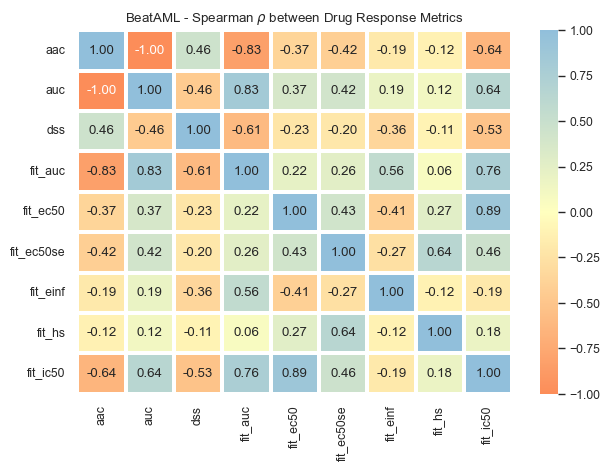

In [19]:
fig, ax = plt.subplots()

sns.heatmap(
    sp_corr,
    ax=ax,
    annot=True,
    linewidth=1.5,
    fmt=".2f",
    cmap="cmap_1",
    robust=True,
    vmin=-1,
    vmax=1,
    )
rho = r"$\rho$"
plt.title(f"{experiment} - Spearman {rho} between Drug Response Metrics")
plt.tight_layout()
plt.savefig(f"{experiment}-spearman-heatmap.pdf")

## Ridge line plots

### Importing all the datasets

In [50]:
local_path = Path('/tmp/coderdata/in')
data_sets_info = cd.list_datasets(raw=True)
# data_sets_info = {'beataml':0, 'ccle':1 , 'fimm': 2}
data_sets = {}
for data_set in data_sets_info.keys():
    data_sets[data_set] = cd.load(name=data_set, local_path=local_path)

Importing raw data ...
Importing 'transcriptomics' from /tmp/coderdata/in/beataml_transcriptomics.csv.gz ... DONE
Importing 'genes' from /tmp/coderdata/in/genes.csv.gz ... DONE
Importing 'drugs' from /tmp/coderdata/in/beataml_drugs.tsv.gz ... DONE
Importing 'proteomics' from /tmp/coderdata/in/beataml_proteomics.csv.gz ... DONE
Importing 'drug_descriptors' from /tmp/coderdata/in/beataml_drug_descriptors.tsv.gz ... DONE
Importing 'mutations' from /tmp/coderdata/in/beataml_mutations.csv.gz ... DONE
Importing 'samples' from /tmp/coderdata/in/beataml_samples.csv ... DONE
Importing 'experiments' from /tmp/coderdata/in/beataml_experiments.tsv.gz ... DONE
Importing raw data ... DONE
Importing raw data ...
Importing 'drugs' from /tmp/coderdata/in/ccle_drugs.tsv.gz ... DONE
Importing 'experiments' from /tmp/coderdata/in/ccle_experiments.tsv.gz ... DONE
Importing 'proteomics' from /tmp/coderdata/in/ccle_proteomics.csv.gz ... DONE
Importing 'transcriptomics' from /tmp/coderdata/in/ccle_transcripto

### Combining the `experiment` objects of all datasets into one DF

In [ ]:
experiments = []
for name, dataset in data_sets.items():
    if dataset.experiments is not None:
        tmp = deepcopy(dataset.experiments)
        tmp['dataset'] = name
        experiments.append(tmp)

df_experiments = pd.concat(experiments, axis=0)

### Defining some functions that will be (re) used later

`rm_outliers` is an optional function to remove outliers form the dataset based on their `dose_response_value`. In the current form this removes everything is more than 3 times the interquartile range removed from the median of the distribution (analogous to 3 standard deviations from the mean)

In [115]:
def rm_outliers(data, metric):
    q = data[metric].quantile([.25, .5, .75])
    iqr = q[.75] - q[.25]
    data_wo_outliers = deepcopy(data)
    data_wo_outliers = data_wo_outliers[(data_wo_outliers[metric] >= (q[.5] - 3*iqr)) & (data_wo_outliers[metric] <= (q[.5] + 3*iqr))]
    return data_wo_outliers

    

- `label()` is a helper function for the plotting via `drug_response_metric_kde_comp()`
- `drug_response_metric_kde_comp()` plots the actual ridge line plot.

In [124]:
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)
            

def drug_response_metric_kde_comp(data, metric, save_plot=False):

      sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
      palette = sns.color_palette("colorblind", 10)

      # create a grid with a row for each 'Language'
      g = sns.FacetGrid(data, palette=palette, row="dataset", hue="dataset", aspect=15, height=.75)

      g.map(sns.kdeplot, metric,
            bw_adjust=.5, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)

      g.map(sns.kdeplot, metric,
            clip_on=False, color="w", lw=2, bw_adjust=.5)


      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates

      g.map(label, metric)

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      if save_plot:
            plt.savefig(f'data_set_comp_{metric}.pdf')

### Plotting the figures

Below we are plotting ridgeline plots for `fit_ic50` & `fit_r2`. Specifically we remove outliers for both measurements for each individual dataset. 
If saving of the plots is desired set `save_plot==True`

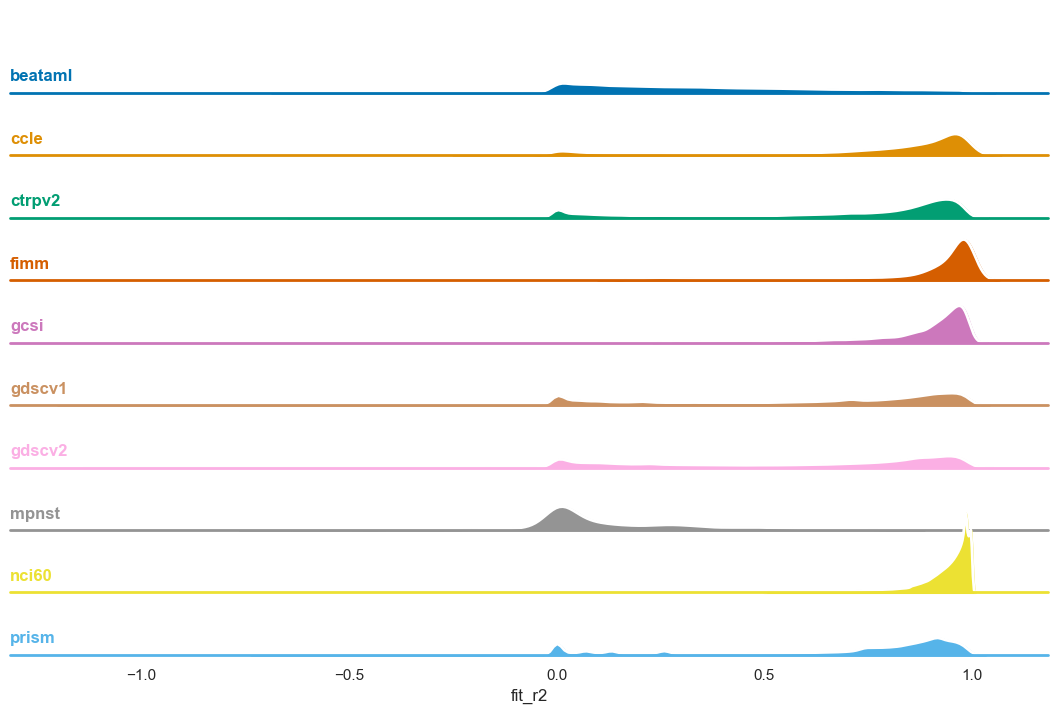

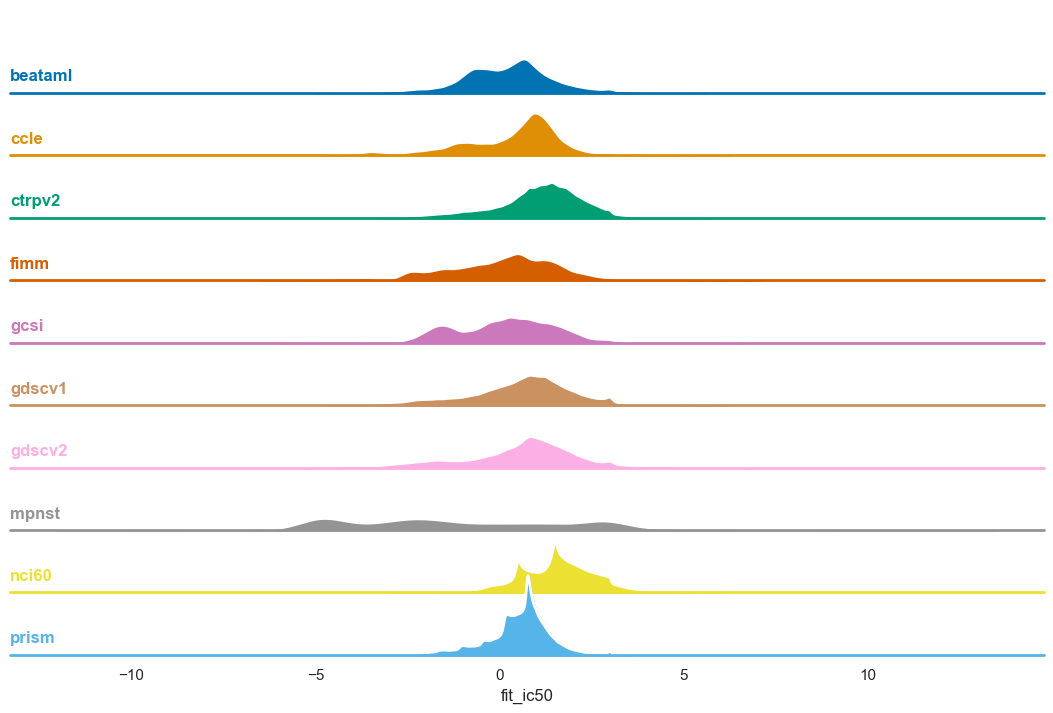

In [129]:
for metric in ['fit_r2', 'fit_ic50']:
    dfs = []
    df_plot = deepcopy(df_experiments[df_experiments['dose_response_metric'] == metric])
    df_plot.rename(columns={'dose_response_value': metric}, inplace=True)
    for dataset in df_plot['dataset'].unique():
        dfs.append(rm_outliers(df_plot[df_plot['dataset'] == dataset], metric))
    df_plot = pd.concat(dfs, axis=0)
    drug_response_metric_kde_comp(df_plot, metric, save_plot=False)    

Same as above for `fit_auc` & `auc` with the exception that for those measurements there aren't any "crazy" outliers, so we don't perform the outlier removal.

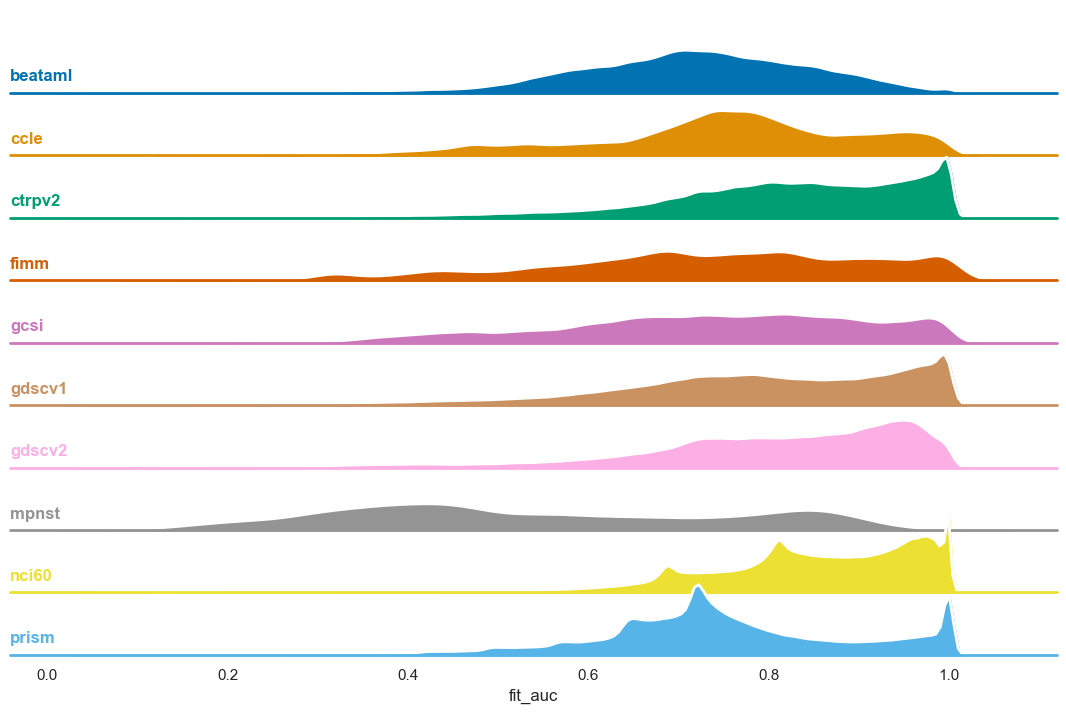

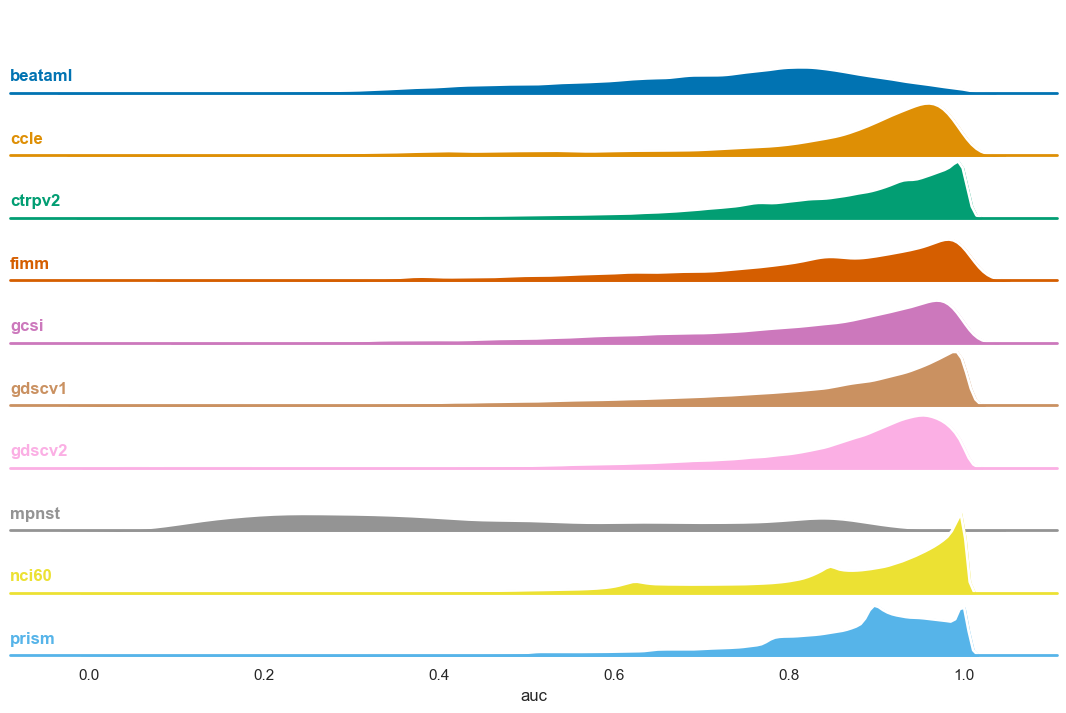

In [130]:
for metric in ['fit_auc', 'auc']:
    df_plot = deepcopy(df_experiments[df_experiments['dose_response_metric'] == metric])
    df_plot.rename(columns={'dose_response_value': metric}, inplace=True)
    drug_response_metric_kde_comp(df_plot, metric, save_plot=False)